**Summary:** 

After finding that we have enough records available to build a model, we compared it with SME's labels with our scores to find any signals/patterns between them. We can see some patterns which correspond to SME labels. 

We are a bit close to the SMEs score in defining the good and worst matches.
- SMEs considering a good match for over-experienced and under-experienced(1 or 2 years less experience) candidates.
- SMEs are considering not just experience but other signals for scoring.

**Objective:**

To identify the patterns between SMEs scores and overall years of experience scoring.

- Why SMEs scored as great matches when our data says worst and vice-a-versa?
- What patterns we can see which can define the worst and great matches?

**Data:**

[labelled data with consensus between 2 labellers](https://s3.console.aws.amazon.com/s3/object/dev-matchology-datascience?region=us-east-1&prefix=data/dice/v2/dice_labeled_20220307_experience_consensus_sandbox.csv)

Features:

- SMEs scores: experience

- BG parsed JD: description_bg_parse_sandbox

- BG parsed resume: resume_bg_parse_sandbox

- Experience extracted from profile data from the database: profile_skills_exp

In [1]:
import os
import pandas as pd
import numpy as np
import json
import datetime


from jsonpath_ng import parse
from IPython.display import HTML
from datetime import datetime, timedelta
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
cursor = connect(s3_staging_dir='s3://aws-athena-query-results-229357985605-us-east-1/',
                 region_name='us-east-1',
                 cursor_class=PandasCursor).cursor()

from dhi.dsmatch import local_bucket
from dhi.dsmatch.sklearnmodeling.models.applytransformer import ApplyTransformer
from dhi.dsmatch.sklearnmodeling.functiontransformermapper import applymap
from dhi.dsmatch.util.io import read_csv
from dhi.dsmatch.preprocess.bgprocessing import datetime_to_julian

In [2]:
# # data = read_csv('s3://dev-matchology-datascience/data/dice/v2/dice_labeled_20220307_experience_consensus_sandbox.csv')
# data.head()

# Pulling profile experience from data pond

In [3]:
# sets = data['snapshot_id'].to_list()
# sql=f"""SELECT  snapshot_id, profile_id, array_join(array_agg(skill_name), ':: ') as profile_skill_data_pond
#                 , array_join(array_agg(skill_years_of_experience), ', ') as profile_skills_exp
#         FROM prod_matchology_annotations.profile_skills 
#         Where snapshot_id in {tuple(sets)}

#         GROUP BY  snapshot_id, profile_id
#         """
# d1 = cursor.execute(sql).as_pandas()
# data = pd.merge(data,d1, on=['snapshot_id','profile_id'])

In [4]:
# data['profile_skill_data_pond'] = data['profile_skill_data_pond'].str.split('::')
# data['profile_skills_exp'] = data['profile_skills_exp'].str.split(', ')
# data['overall_exp_res_prof'] = data['profile_skills_exp'].apply(lambda x: int(max(x)))
# data['overall_exp_res_prof'] =data['overall_exp_res_prof'].clip(lower=-1, upper=25)

In [5]:
# data.to_csv(os.path.join(local_bucket,'data', 'dice', 'new-bg-parsing-2022','labeled_data_exp.csv'),index=False)


# BG parsing

In [6]:
data = read_csv(os.path.join(local_bucket,'data', 'dice', 'new-bg-parsing-2022','labeled_data_exp.csv'))

In [9]:
def job_field_parsing(d, match_pattern):
    jsonpath_expr = parse(match_pattern)
    matches = [match.value for match in jsonpath_expr.find(d)]
    ret = ', '.join(matches)
    if len(ret) == 0:
        return '-1'
    return ret

def extract_resume_overall_experience(d: dict) -> int:
    """
    """
    try:
        explist = d['responseData']['ResDoc']['resume']['experience']
        if not isinstance(explist, list):
            explist = [explist]
        try:
            max_end = int(d['responseData']['ResDoc']['resume']['@present'])
        except KeyError:
            max_end = datetime_to_julian(datetime.today())
        
        try:
            min_start = int(d['responseData']['ResDoc']['resume']['@present'])
        except KeyError:
            min_start = datetime_to_julian(datetime.today())
        
        try:
            jsonpath_expr = parse(f'$..@end')
            ends = np.array(list(map(int, [match.value for match in jsonpath_expr.find(d)])))
            max_end = ends.max()
        except:
            pass
        
        try:
            jsonpath_expr = parse(f'$..@start')
            starts = np.array(list(map(int, [match.value for match in jsonpath_expr.find(d)])))
            min_start = starts.min()
        except:
            pass
        
        return max_end - min_start  # In days
    
    except KeyError:
        pass
    return -1

JSON loads

In [8]:
jsonloads_tx = ApplyTransformer(applymap, json.loads, keys=['description_bg_parse_sandbox', 'resume_bg_parse_sandbox'])
jsonloads_tx.transform(data)
data.head()

loads:   0%|          | 0/45 [00:00<?, ?it/s]

,snapshot_id,year,month,day,worker_email,experience,titles,skills,overall,previous_title,...,application_id,resume_detected_lang,set,resume_bg_parse_sandbox,description_bg_parse_sandbox,description_bg_skills_sandbox,resume_bg_skills_sandbox,profile_skill_data_pond,profile_skills_exp,overall_exp_res_prof
0,f699d3fa-5fcd-553d-9326-8b6d9a7ab0b6,2021,2,5,thellmuth@iqclarity.com,5.0,4.0,4.0,4.0,NaN,...,2c928082773ade8c017774437af72b66,en,test,"{'status': True, 'statusCode': 'OK', 'requestI...","{'status': True, 'statusCode': 'OK', 'requestI...","['Apigee', 'TIBCO']","['ANSI X12', 'Apache Subversion (SVN)', 'Apige...","['Integration', ' TIBCO', ' WTX', ' ASC X12', ...","['10', '10', '10', '10', '10', '10', '10', '10...",10
1,6781e17d-0d57-5339-91c7-b9ea89aa0f66,2021,2,5,thellmuth@iqclarity.com,3.0,2.0,2.0,2.0,Network / Security Architect:: Network / Secur...,...,2c928082773ade8c01777346a4a26f88,en,test,"{'status': True, 'statusCode': 'OK', 'requestI...","{'status': True, 'statusCode': 'OK', 'requestI...","['AWS Elastic Compute Cloud (EC2)', 'Ansible',...","['AWS Lambda', 'Accounting Systems', 'Apache A...","['Architecture', ' VoIP', ' Ubuntu', ' Data ce...","['35', '29', '29', '27', '26', '25', '25', '25...",25
2,8f026a65-0404-5a03-b96f-32f13535347e,2021,2,3,thellmuth@iqclarity.com,3.0,3.0,3.0,3.0,NaN,...,2c928082773ade8c01776647527f5c07,en,train,"{'status': True, 'statusCode': 'OK', 'requestI...","{'status': True, 'statusCode': 'OK', 'requestI...","['Code Reviews', 'Communication Skills', 'Cont...","['Authentication', 'AutoCAD', 'Calculus', 'Cat...","['CSS', ' Express.js', ' GitHub', ' HTML', ' H...","['2', '2', '1', '2', '2', '2', '0', '2', '2', ...",2
3,9dc1f84a-dc8d-5e2b-bddd-a0d38a9b5248,2021,2,7,thellmuth@iqclarity.com,4.0,4.0,4.0,4.0,Senior IT Security Assessment Analyst:: Securi...,...,2c928082773adea001777a5f70073d8b,en,test,"{'status': True, 'statusCode': 'OK', 'requestI...","{'status': True, 'statusCode': 'OK', 'requestI...","['Agency Selection', 'Bash', 'Change Managemen...","['Anomaly Detection', 'Authentication', 'COBIT...","['DNS', ' Security operations', ' Authenticati...","['5', '4', '4', '4', '4', '4', '4', '4', '3', ...",5
4,010d401d-295d-56f6-883d-188b9d2e82fb,2021,2,5,thellmuth@iqclarity.com,4.0,4.0,4.0,4.0,Python Developer:: DevOps Systems Engineer:: S...,...,2c928082773ade9a0177701809f548f5,en,test,"{'status': True, 'statusCode': 'OK', 'requestI...","{'status': True, 'statusCode': 'OK', 'requestI...","['C++', 'Data Science', 'Data Structures', 'De...","['API Management', 'AWS CodeBuild', 'AWS Elast...","['javascript / nodejs', ' DevOps Systems Autom...","['3', '7', '2', '3', '10', '7', '4', '2', '11'...",9


# Job extraction

In [10]:


tx = ApplyTransformer(applymap, job_field_parsing, 
                      fkwargs=dict(match_pattern='$..@experience-min'))
data['overall_experience_job'] = tx.transform(data['description_bg_parse_sandbox'])
data['overall_experience_job'] = data['overall_experience_job'].astype(float)
idxs = data[data['overall_experience_job'] > -1].index
data.loc[idxs, 'overall_experience_job'] /= 12


job_field_parsing:   0%|          | 0/45 [00:00<?, ?it/s]

<AxesSubplot:>

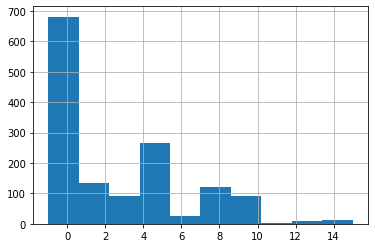

In [11]:
data['overall_experience_job'].hist()

In [13]:
data['overall_experience_job'] = data['overall_experience_job'].apply(lambda x : x if x>0 else np.nan)


# Resume experience Parsing from BG

In [14]:
tx = ApplyTransformer(applymap, extract_resume_overall_experience)
data['overall_exp_res_bg'] = tx.transform(data['resume_bg_parse_sandbox'])
idxs = data[data['overall_exp_res_bg'] > -1].index
data.loc[idxs, 'overall_exp_res_bg'] /= 365
data['overall_exp_res_bg'] =data['overall_exp_res_bg'].clip(lower=-1, upper=25)


extract_resume_overall_experience:   0%|          | 0/45 [00:00<?, ?it/s]

<AxesSubplot:>

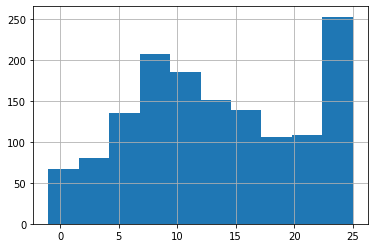

In [15]:
data['overall_exp_res_bg'].hist()

# combining BG and profile experience and taking a mean as overall exp of resume.

In [16]:
data['overall_exp_res_bg'] =data['overall_exp_res_bg'].apply(lambda x : x if x>0 else np.nan)
data['overall_exp_res_prof'] =data['overall_exp_res_prof'].apply(lambda x : x if x>0 else np.nan)

data['overall_exp_res_prof'] = data['overall_exp_res_prof'].fillna(data['overall_exp_res_bg'])#filling NaNs with profile data
data['overall_exp_res_bg']   = data['overall_exp_res_bg'].fillna(data['overall_exp_res_prof'])#filling NaNs with BG data

data['overall_experience_resume'] =  (data['overall_exp_res_prof']+data['overall_exp_res_bg'])/2


<AxesSubplot:>

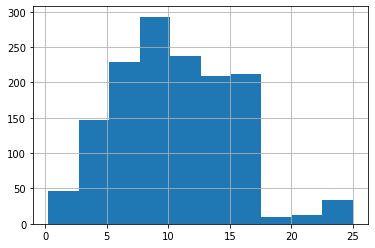

In [17]:
data['overall_experience_resume'] .hist()

Final overall experince features

In [18]:
data[['overall_experience_resume','overall_experience_job']]

,overall_experience_resume,overall_experience_job
0,11.045205,0.5
1,25.000000,8.0
2,2.000000,7.0
3,8.087671,NaN
4,10.754795,NaN
...,...,...
1428,7.713699,NaN
1429,15.927397,NaN
1430,15.000000,4.0
1431,1.501370,2.0


In [19]:
# data.to_csv(os.path.join(local_bucket,'data', 'dice', 'new-bg-parsing-2022','labeled_data_for_victor_EDA_analysis.csv'))

In [20]:
data['overall_experience_resume'] = data['overall_experience_resume'].apply(lambda x : x if x>0 else np.nan)


23     0.331507
70     0.249315
835    0.583562
Name: overall_experience_resume, dtype: float64

We compared the SMS scores to the overall job and Resume year of experience. Here we rae substracting resume with job experice and call it as distance from job to qualify for a mtach.

In [21]:
def calc_distance(data):
    dist = []
    for j, r in zip(data['overall_experience_job'],data['overall_experience_resume']):
        
        if (j!=np.nan) | (r!=np.nan):
            d = r-j
            dist.append(d)
        else:
            dist.append(np.nan)
    data['dist'] = dist
    return data
data = calc_distance(data)

In [22]:
data [['overall_experience_job','overall_experience_resume','dist']]

,overall_experience_job,overall_experience_resume,dist
0,0.5,11.045205,10.545205
1,8.0,25.000000,17.000000
2,7.0,2.000000,-5.000000
3,NaN,8.087671,NaN
4,NaN,10.754795,NaN
...,...,...,...
1428,NaN,7.713699,NaN
1429,NaN,15.927397,NaN
1430,4.0,15.000000,11.000000
1431,2.0,1.501370,-0.498630


Normal dist distribution where negetive says less experince to qualify for a match on job scale. positive is a good match.

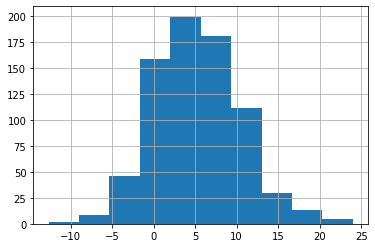

In [23]:
data['dist'][data['dist'].notnull()].hist();

Resume that have same or above experinec mentined in  job. 

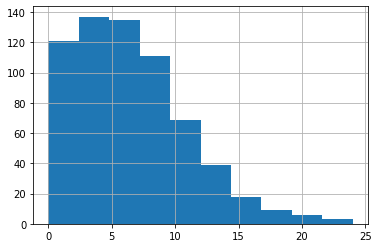

In [24]:
data_ = data['dist'][data['dist']>=0]
display(HTML(f'<h2>{data_.shape[0]/data.shape[0]}% data have more or same experinece as mentioned in Job</h2>'))
data_.hist();

The graph below showing the SME labels in color where jobs on y-axis and resume experience on x_axis. The black diagonal line is presenting a threshold where good match(red,orangeand green dots) should be below the line and worst matches(dark blue and skyblue) above the line. There is  not quite clear signals but mostly lighter color dots are above the line and darker below the line.

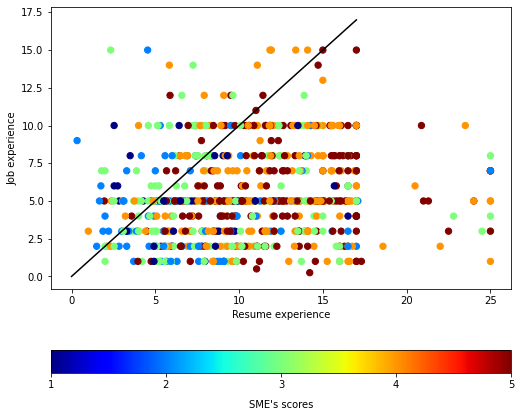

In [58]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,7))
ax = fig.add_axes([.1, .1, .8, .8])
cax =ax.scatter(data['overall_experience_resume'], data['overall_experience_job'], 
               c=data['experience'],
               cmap='jet', s=40)
ax.set_xlabel("Resume experience")
ax.set_ylabel("Job experience")
ax.plot([0, 17], [0, 17], color='black', lw=1.5)
cbar = fig.colorbar(cax, ticks=[1, 2, 3,4,5], orientation='horizontal')
cbar.set_label("SME's scores", labelpad=10, y=10, rotation=0)
cbar.ax.set_xticklabels(['1', '2', '3', '4', '5']) ;

The graph below showing the SME's scores on distance between resume and job to qualify for a match, where -getive numbers are saying the resume does not have experinnce above than the experinece asked in the job. For example candidate has 8 years of experince where job is asking for 10 years. To qualify for a good or ok kind of match the red green and orange dots must lie between the two black lines shown in the graph.We can see most of the blue and green dots are left side of the line, but still not a clear pattern to define then SME's leabels in our dataset..

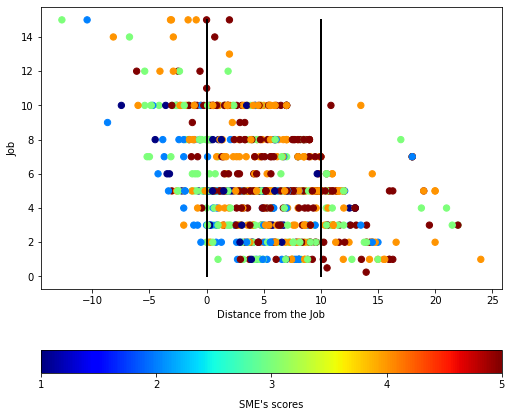

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,7))
ax = fig.add_axes([.1, .1, .8, .8])
cax =ax.scatter(data['dist'], data['overall_experience_job'], 
               c=data['experience'],
               cmap='jet', s=40)
ax.set_xlabel("Distance from the Job")
ax.set_ylabel("Job")
ax.plot([0, 0], [0, 15], color='black', lw=2)
ax.plot([10, 10], [0, 15], color='black', lw=2)
cbar = fig.colorbar(cax, ticks=[1, 2, 3, 4, 5], orientation='horizontal')
cbar.set_label("SME's scores", labelpad=10, y=10, rotation=0)
cbar.ax.set_xticklabels(['1', '2', '3', '4', '5']) ;

Data where SME's has rates less but we are scoring as a good match. lesser the distance(but greater than zero), better is the macth.

- index 304 not have relevent experinece in the same domain which seems like SME not just looking the overall expreience but experience in relevent domain for scoring.
- 394 BG parsing is incorrect
- 493 mentioned incorrect profile skill experience
- 999 disagree with SME's scores
- 1002

In [27]:
d_ = data[(data['dist']>0) & (data['dist']<2)].reset_index()
d_ = d_[d_['experience']<3]

In [28]:

cols = ['index','overall_experience_job','overall_exp_res_prof','overall_exp_res_bg','overall_experience_resume','dist','experience']
d_[cols][d_['dist']>-2]

,index,overall_experience_job,overall_exp_res_prof,overall_exp_res_bg,overall_experience_resume,dist,experience
19,304,4.0,2.0,7.167123,4.583562,0.583562,2.0
30,394,5.0,3.0,7.457534,5.228767,0.228767,2.0
35,493,5.0,6.0,4.169863,5.084932,0.084932,2.0
36,499,5.0,6.0,5.169863,5.584932,0.584932,2.0
42,605,5.0,5.0,6.257534,5.628767,0.628767,2.0
45,616,5.0,9.0,3.589041,6.294521,1.294521,2.0
47,693,4.0,1.0,8.838356,4.919178,0.919178,2.0
48,694,8.0,5.0,13.090411,9.045205,1.045205,1.0
53,807,5.0,4.0,6.591781,5.295890,0.295890,1.0
58,893,2.0,2.0,4.589041,3.294521,1.294521,2.0


In [29]:
n=1002
cols = ['index','overall_experience_job','overall_exp_res_prof','overall_exp_res_bg','overall_experience_resume','dist','experience']
for c in cols[1:]:
    display(HTML(f'{c}: {data[c][n]}'))
display(HTML(data['job_description'][n]))
display(HTML(data['resume'][n]))


While eyeballing some of the examples we found the SME's are scoring experince on the basis of skills and experince

- index 0 do not agree with SME's scores, it is asking 6 month experince and 10 years expert applied and SME's scored as 5.
- index 9 over qualified people gets a score 5.

In [30]:
d_ = data[(data['dist']<12) & (data['dist']>5)].reset_index()
d_ = d_[d_['experience']>2]
cols = ['index','overall_experience_job','overall_exp_res_prof','overall_exp_res_bg','overall_experience_resume','dist','experience']
d_[cols][d_['dist']>-2]

,index,overall_experience_job,overall_exp_res_prof,overall_exp_res_bg,overall_experience_resume,dist,experience
0,0,0.5,10.0,12.090411,11.045205,10.545205,5.0
1,9,6.0,8.0,23.602740,15.801370,9.801370,5.0
2,10,2.0,9.0,9.506849,9.253425,7.253425,3.0
3,16,5.0,8.0,13.928767,10.964384,5.964384,3.0
4,33,1.0,9.0,9.594521,9.297260,8.297260,3.0
...,...,...,...,...,...,...,...
294,1408,5.0,9.0,14.673973,11.836986,6.836986,4.0
295,1424,2.0,9.0,10.169863,9.584932,7.584932,3.0
296,1426,3.0,9.0,15.178082,12.089041,9.089041,5.0
297,1430,4.0,5.0,25.000000,15.000000,11.000000,3.0


In [31]:
n=10
cols = ['index','overall_experience_job','overall_exp_res_prof','overall_exp_res_bg','overall_experience_resume','dist','experience']
for c in cols[1:]:
    display(HTML(f'{c}: {data[c][n]}'))
display(HTML(data['job_description'][n]))
display(HTML(data['resume'][n]))

distribution of SMS's scores and oyr scoring as the distance increasing toward positive matcjes also increaing. This says SME's are not penelizing overqualified candidates.

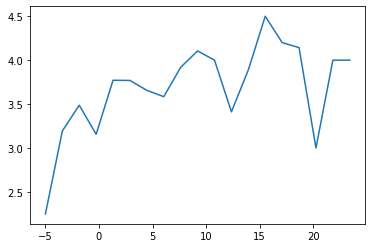

In [36]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)
bins = np.linspace(-5, 25, 20)
colors = []
c= ['b','g','y','r','o']
for b1,b2 in pairwise(bins):
    colors.append(data['experience'][(data['dist']>=b1) & (data['dist']<b2)].mean())
plt.plot(bins[:-1], colors);


# To analyse the SME's scoring when resume has less experince than the job.

In [40]:
d_ = data[(data['dist']<0) & (data['dist']>-5)].reset_index()
d_ = d_[d_['experience']>3]
cols = ['index','overall_experience_job','overall_exp_res_prof','overall_exp_res_bg','overall_experience_resume','dist','experience']
d_[cols]

,index,overall_experience_job,overall_exp_res_prof,overall_exp_res_bg,overall_experience_resume,dist,experience
1,12,15.0,9.0,19.180822,14.090411,-0.909589,4.0
4,103,10.0,7.0,7.758904,7.379452,-2.620548,5.0
8,165,12.0,9.0,10.010959,9.505479,-2.494521,5.0
10,218,10.0,7.0,8.424658,7.712329,-2.287671,4.0
12,238,10.0,8.0,10.342466,9.171233,-0.828767,5.0
14,278,8.0,9.0,3.917808,6.458904,-1.541096,5.0
18,377,9.0,6.0,9.506849,7.753425,-1.246575,5.0
20,405,10.0,7.0,9.424658,8.212329,-1.787671,4.0
24,452,10.0,8.0,9.846575,8.923288,-1.076712,4.0
25,464,4.0,2.0,5.172603,3.586301,-0.413699,5.0


In [41]:
n=12
cols = ['index','overall_experience_job','overall_exp_res_prof','overall_exp_res_bg','overall_experience_resume','dist','experience']
for c in cols[1:]:
    display(HTML(f'{c}: {data[c][n]}'))
display(HTML(data['job_description'][n]))
display(HTML(data['resume'][n]))

Why we have mostly blue and sky blue dots on the left side of the black line?
- index 382, incorrect parsing, incorrect mentioned skills experience
- index 1076, not a good match




In [51]:
d_ = data[(data['dist']<0) & (data['dist']>-5)].reset_index()
d_ = d_[d_['experience']<3]
cols = ['index','overall_experience_job','overall_exp_res_prof','overall_exp_res_bg','overall_experience_resume','dist','experience']
d_[cols]

,index,overall_experience_job,overall_exp_res_prof,overall_exp_res_bg,overall_experience_resume,dist,experience
2,29,7.0,5.0,1.586301,3.293151,-3.706849,2.0
11,224,5.0,5.0,4.504110,4.752055,-0.247945,2.0
17,362,10.0,5.0,5.589041,5.294521,-4.705479,2.0
19,382,5.0,4.0,4.583562,4.291781,-0.708219,1.0
22,437,8.0,7.0,5.005479,6.002740,-1.997260,2.0
23,448,8.0,3.0,11.846575,7.423288,-0.576712,1.0
29,524,8.0,7.0,6.843836,6.921918,-1.078082,2.0
30,538,3.0,1.0,3.421918,2.210959,-0.789041,2.0
32,563,6.0,2.0,3.506849,2.753425,-3.246575,1.0
33,565,5.0,2.0,1.334247,1.667123,-3.332877,2.0


In [52]:
n=524
cols = ['index','overall_experience_job','overall_exp_res_prof','overall_exp_res_bg','overall_experience_resume','dist','experience']
for c in cols[1:]:
    display(HTML(f'{c}: {data[c][n]}'))
display(HTML(data['job_description'][n]))
display(HTML(data['resume'][n]))

# Distribution of SME's scores and distance to qualify for a match.

We can see below when SME is scoring 5 they are not penelizing candidates which are closer to the match. they are scoring good matches when candidate have less experince than asked in the job. And they are not penelizing for overqualified candiates in the figure they have scored % to the candidate those have 10 years over experince than asked. 

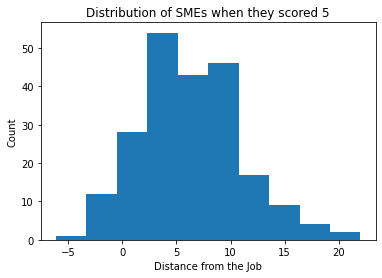

In [64]:
fig, ax = plt.subplots()
ax.hist(data['dist'][data['experience']==5])
ax.set_title('Distribution when SMEs scored 5(great match)')
ax.set_xlabel("Distance of candidate experince to qualify for a Job experience")
ax.set_ylabel("Count");

<AxesSubplot:>

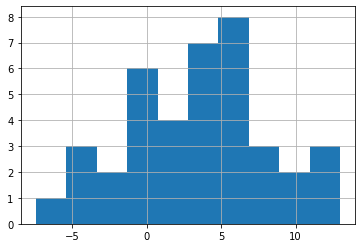

In [67]:
data['dist'][data['experience']<2].hist()

**Findings:**

- Overexperienced individuals are not penalized by SMEs, and they are rated as excellent matches.
- Candidates with less experience than the job requirements are rated as good matches.
- For scoring, SMEs possibly considered other signals like skills, domain,  and education with experience.
- Outliers are mostly bad parsing/ incorrect experiences mentioned by candidates.

**Conclusion:**
We can see some patterns above with SMEs scoring that corresponds to our scoring. We can see worst and good matches clusters easily, the patterns are a little bit clear not much but have a positive signal that we are moving in the right direction. We need to investigate more SMEs scoring techniques.

**Next Steps:**
- Understanding the product demand for the model. 
- Exploring potential signals like skills, education, domain, etc to align with SMEs scores.
